# Constraints

[Try this yourself](https://colab.research.google.com/github/DTUWindEnergy/TopFarm2/blob/master/docs/notebooks/constraints.ipynb) (requires google account)


In [0]:
%%capture
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install topfarm
# Install Topfarm if needed

Constraints are the second key element of a an optimization problem formulation. They ensure that the optimization results conforms to feasible / realistic solutions.  There are three types of constraints in optimization:
* Variable bounds - upper and lower boundary values for design variables
* inequality constraints - constraint function values must be less or more than a given threshold
* equality constraints - constraint function must be exactly equal to a value (not as commonly used)

This notebook walks through a process to set up typical constraints in Topfarm for wind farm design problems including:
* boundary constraints - these tell Topfarm within a region where the perimeter of the site is that turbines must be sited within and also any exclusion zones that must be avoided
* spacing constraints - these tell Topfarm the minimum allowable inter-turbine spacing in the farm

**First we import supporting libraries in Python numpy and matplotlib**

In [21]:
# Import numpy and matplotlib files
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

**Next we import and initialize several functions and classes from Topfarm to set up the problem including:**
* **TopFarmProblem - overall topfarm problem class to which the objectives, design variables, and constraints are added**
* **XYBoundaryConstraint - for a boundary specified as a series of connected perimeter vertices**
* **CircleBoundaryConstraint - for a circular boundary with a central location and a radius**
* **SpacingConstraint - for the inter-turbine spacing distance constraints**
* **CostModelComponent - a generic class for setting up a problem objective function**

**We also import a helper function to plot**

**For documentation on Topfarm see:**
https://topfarm.pages.windenergy.dtu.dk/TopFarm2/user_guide.html#

In [22]:
# Import topfarm problem, plotting support, constraint classes and generic cost model component
from topfarm import TopFarmProblem
from topfarm.plotting import XYPlotComp
from topfarm.constraint_components.boundary import XYBoundaryConstraint, CircleBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.cost_models.cost_model_wrappers import CostModelComponent

## Boundary constraints

**Next we are going to demonstrate the use of the XYBoundaryConstraint to set up site boundaries of a variety of types including square, rectangle and an arbitrary polygon.  Additionally, a "convex hull" example is provided which is a commonly used boundary type for wind farm design optimization problems.**

**(From wikipedia) In mathematics, the convex hull or convex envelope or convex closure of a set X of points in the Euclidean plane or in a Euclidean space (or, more generally, in an affine space over the reals) is the smallest convex set that contains X. For instance, when X is a bounded subset of the plane, the convex hull may be visualized as the shape enclosed by a rubber band stretched around X.**

In [23]:
# set up a "boundary" arry with arbitrary points for use in the example
boundary = np.array([(0, 0), (1, 1), (3, 0), (3, 2), (0, 2)])

# set up dummy design variables and cost model component. 
# This example includes 2 turbines (n_wt=2) located at x,y=0.5,0.5 and 1.5,1.5 respectively
x = [0.5,1.5]
y = [.5,1.5]
dummy_cost = CostModelComponent(input_keys=[],
                                n_wt=2,
                               cost_function=lambda : 1)   

# We introduce a simple plotting function so we can quickly plot different types of site boundaries
def plot_boundary(name, constraint_comp):
    tf = TopFarmProblem(
        design_vars={'x':x, 'y':y}, # setting up our two turbines as design variables
        cost_comp=dummy_cost, # using dummy cost model
        constraints=[constraint_comp], # constraint set up for the boundary type provided
        plot_comp=XYPlotComp()) # support plotting function
    
    plt.figure()
    plt.title(name)
    tf.plot_comp.plot_constraints() # plot constraints is a helper function in topfarm to plot constraints
    plt.plot(boundary[:,0], boundary[:,1],'.r', label='Boundary points') # plot the boundary points
    plt.axis('equal')
    plt.legend() # add the legend



**Now that we have set up our dummy problem, we can illustrate how different boundary types can be created from our boundary vertices**

**First we show a convex hull type as described above. Note that for the convex hull, all boundary points are contained within a convex perimeter but one of the boundary points on the interior is not used.**

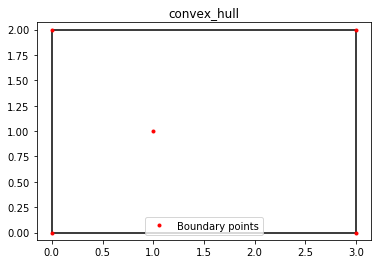

In [24]:
# Now we use our boundary defined above to plot different types of boundary constraints on the problem
plot_boundary('convex_hull', XYBoundaryConstraint(boundary, 'convex_hull'))

**Next we show a square type of boundary. In this case the maximum distance between the x and y elements of the vertices is used to establish the perimeter.**

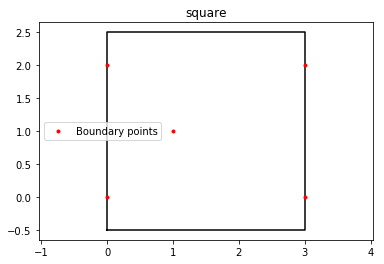

In [25]:
plot_boundary('square', XYBoundaryConstraint(boundary, 'square'))

**Now a rectangle boundary. Here we use the maximum distance on both x and y axes of the boundary coordinates to establish the perimeter.**

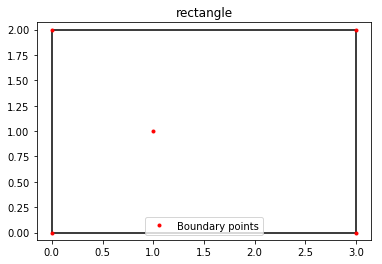

In [26]:
plot_boundary('rectangle', XYBoundaryConstraint(boundary, 'rectangle'))

**Now a polygon boundary. This connects all the points in sequence. Note that this results in a nonconvex boundary. Nonconvex functions in optimization problems introduce complexity that can be challenging to handle and often require more sophisticated algorithms and higher computational expense.**

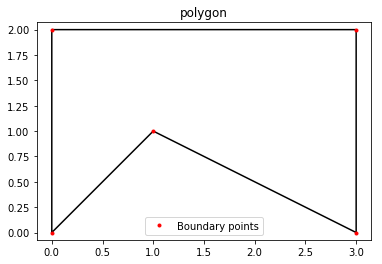

In [27]:
plot_boundary('polygon', XYBoundaryConstraint(boundary, 'polygon'))

**Finally a circular boundary. For this we have to specify the midpoint of the circle and the radius.**

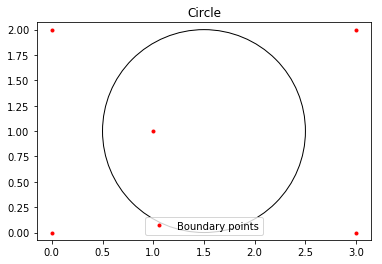

In [28]:
plot_boundary('Circle',CircleBoundaryConstraint((1.5,1),1))  

**You can also quickly plot all boundary types using some quick python tricks**

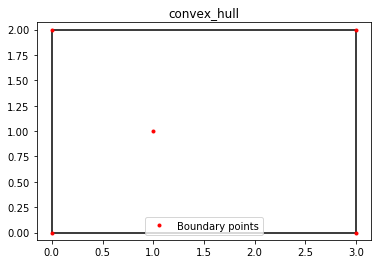

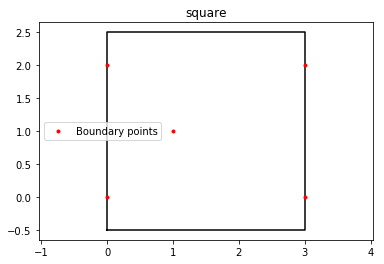

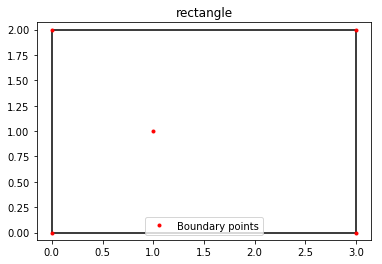

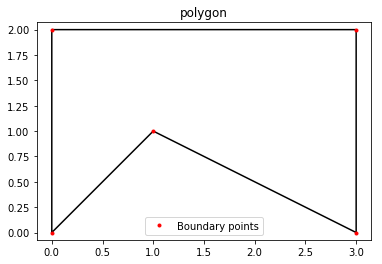

In [29]:
# plot all boundary types using our dummy problem and boundaries
for boundary_type in ['convex_hull','square','rectangle','polygon']:
    plot_boundary(boundary_type, XYBoundaryConstraint(boundary, boundary_type))

### Exercise!!

**Now play around with a new set of boundary vertices and construct different perimeters to explore the functionality. See if you can make even more complex polygon shapes.**

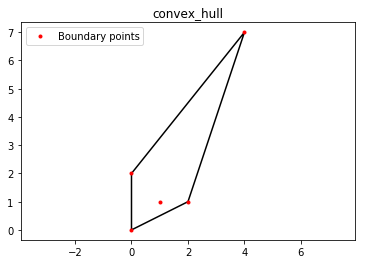

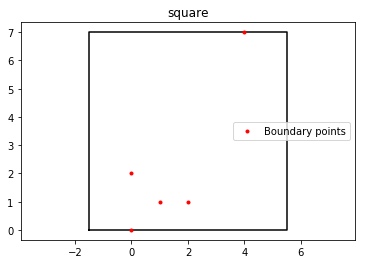

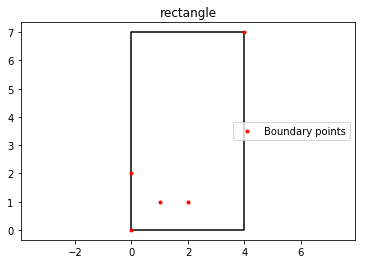

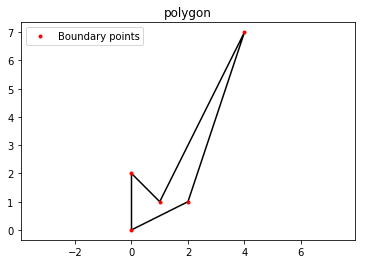

In [30]:
# Make your own set of vertices - anything you would like!
boundary = np.array([(0, 0), (2, 1), (4, 7), (1, 1), (0, 2)])

# Then see what types of perimeters they generate
for boundary_type in ['convex_hull','square','rectangle','polygon']:
    plot_boundary(boundary_type, XYBoundaryConstraint(boundary, boundary_type))

## Spacing constraints

The next most common constraint in a wind farm design optimization problem is on the allowable inter-turbine spacing in the farm.  Losses due to wakes should ensure that turbines do spread out but a minimum constraint can also help to ensure that turbines do not get placed too close together.

The following provides a simple example of implementation of a minimum spacing constraint.

**Implement a minimum spacing constraint example**

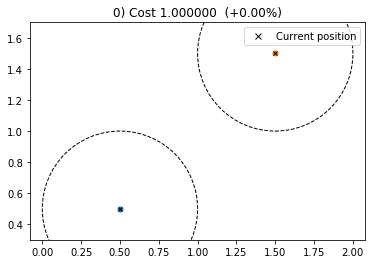

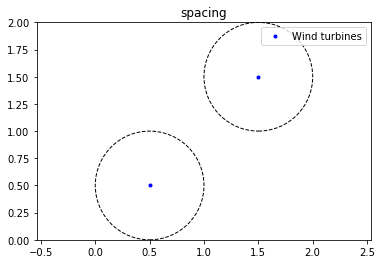

In [31]:
# set up dummy design variables and cost model component. 
# This example includes 2 turbines (n_wt=2) located at x,y=0.5,0.5 and 1.5,1.5 respectively
x = [0.5,1.5]
y = [.5,1.5]
dummy_cost = CostModelComponent(input_keys=[],
                                n_wt=2,
                               cost_function=lambda : 1)   

# a function to plot a spacing constraint for a Topfarm problem
def plot_spacing(name, constraint_comp):
    tf = TopFarmProblem(
        design_vars={'x':x, 'y':y}, # setting up our two turbines as design variables
        cost_comp=dummy_cost, # using dummy cost model
        constraints=[constraint_comp], # constraint set up for the boundary type provided
        plot_comp=XYPlotComp()) # support plotting function
    tf.evaluate()
    plt.figure()
    plt.title(name)
    tf.plot_comp.plot_constraints() # plot constraints is a helper function in topfarm to plot constraints
    plt.plot(x,y,'.b', label='Wind turbines') # plot the turbine locations
    plt.axis('equal')
    plt.legend() # add the legend
    plt.ylim([0,2]) 
                          
plot_spacing('spacing', SpacingConstraint(1))

### Exercise!!

**Play around with the spacing constraint size**

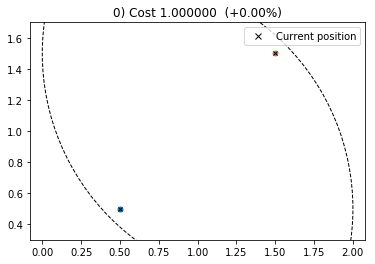

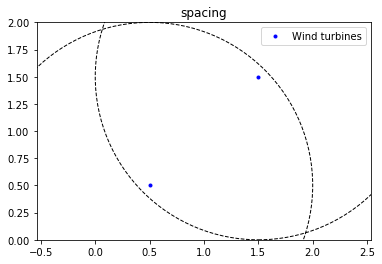

In [32]:
plot_spacing('spacing', SpacingConstraint(3))